# Grape2 Spectrogram Generator

Author: Cuong Nguyen

Date     | Version     | Author | Comments
---------|-------------|--------|-----------
01-04-24 | Ver 1.00.00 | KC3UAX | Initial commit
01-25-24 | Ver 1.01.00 | KC3UAX | Optimize the program with multiprocessing and clean up

## Imports and Setup

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from pathlib import Path

%matplotlib inline

In [2]:
# Matplotlib settings to make the plots look a little nicer.
plt.rcParams['font.size']      = 12
# plt.rcParams['font.weight']    = 'bold'
plt.rcParams['axes.grid']      = False
plt.rcParams['axes.xmargin']   = 0
# plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.figsize'] = (20,6)

## User Inputs

In [3]:
fs = 8000
dir_path = "SpareData"
csv_file = "2024-01-30_05MHZ_Sine_R1_RAWDATA.csv"

## Find the Indices of the Rows to be Skipped by CSV Reader

In [4]:
def find_rows_with_characters(file_path):
    row_numbers = []

    with open(file_path, "r") as file:
        for row_number, line in enumerate(file):
            if line[0] in ["#", "T", "C", ","]:
                row_numbers.append(row_number)

    return row_numbers

## Read Datafiles

In [5]:
def load_data(file):
    file_path = os.path.join(dir_path, file)
    exclude = find_rows_with_characters(file_path)
    df = pd.read_csv(
        file_path,
        names=range(3),
        skiprows=exclude,
        header=None,
        converters={col: (lambda x: int(x, 16)) for col in range(3)},
    )
    return df

In [6]:
df = load_data(csv_file)

In [7]:
df

,0,1,2
0,40706,32562,32494
1,28164,32539,32484
2,18155,32525,32492
3,16596,32524,32506
4,24400,32538,32521
...,...,...,...
28799995,22998,32562,32517
28799996,16250,32542,32501
28799997,19092,32529,32488
28799998,29813,32530,32485


## Raw Signals

In [8]:
def create_time_vector(fs, num_secs):
    # Create time vector
    Ts    = 1/fs  # Convert to sampling period
    
    # t_max = 24*60*60.                 # Time max in seconds.
    N     = num_secs*fs          # Total number of samples
    
    return np.arange(0,N)*Ts              # Time vector in seconds

In [9]:
def plot_sinusoid(t, df):
    # Plot the sinusoid.
    xlim = None
    # ylim = (-3, 3)
    ylim = None
    
    fig = plt.figure(figsize=(12, 10))
    
    ax = fig.add_subplot(3, 1, 1)
    ax.plot(t, df[0])
    ax.set_ylabel("Radio 0")
    ax.set_xticklabels([])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ax = fig.add_subplot(3, 1, 2)
    ax.plot(t, df[1])
    ax.set_ylabel("Radio 1")
    ax.set_xticklabels([])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ax = fig.add_subplot(3, 1, 3)
    ax.plot(t, df[2])
    ax.set_xlabel("t [s]")
    ax.set_ylabel("Radio 2")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    fig.tight_layout()
    plt.show()

In [10]:
def plot_sinusoid(t, df, index):
    # Plot the sinusoid.
    xlim = (1,1.01)
    # xlim = (0.515,0.525)
    # ylim = (-3, 3)
    # ylim = (32500,32515)
    ylim = None
    fig = plt.figure(figsize=(12, 10))
    
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(t, df[index])
    ax.set_title(Path(csv_file).stem+"_TIME")
    ax.set_xlabel("t [s]")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    fig.tight_layout()
    plt.show()

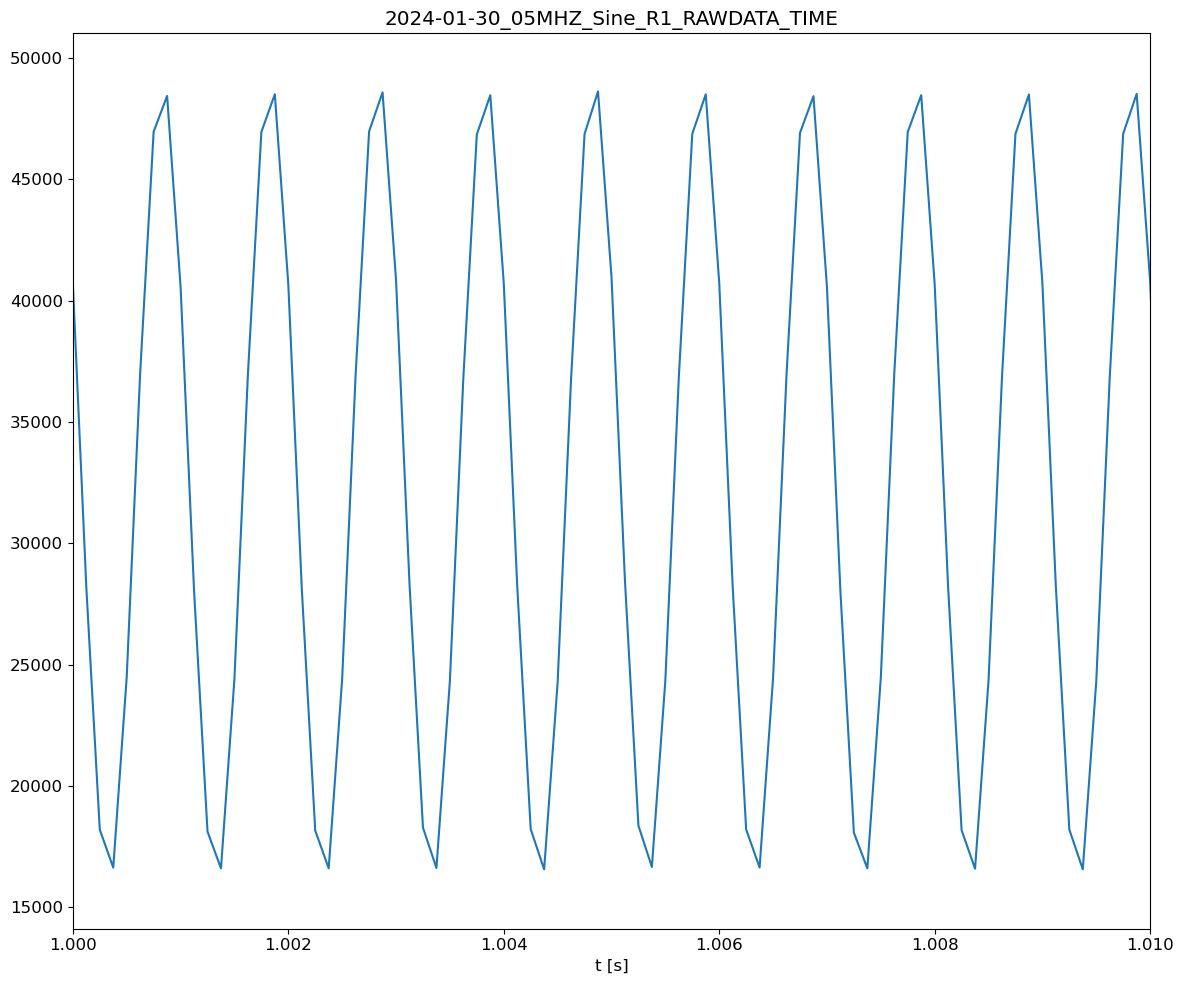

In [11]:
plot_sinusoid(create_time_vector(fs, 60*60),df,0)

## Spectrograms

In [10]:
f, t_spec, Sxx = signal.spectrogram(df[2],fs=fs,window='hann')
Sxx_db = 10*np.log10(Sxx)

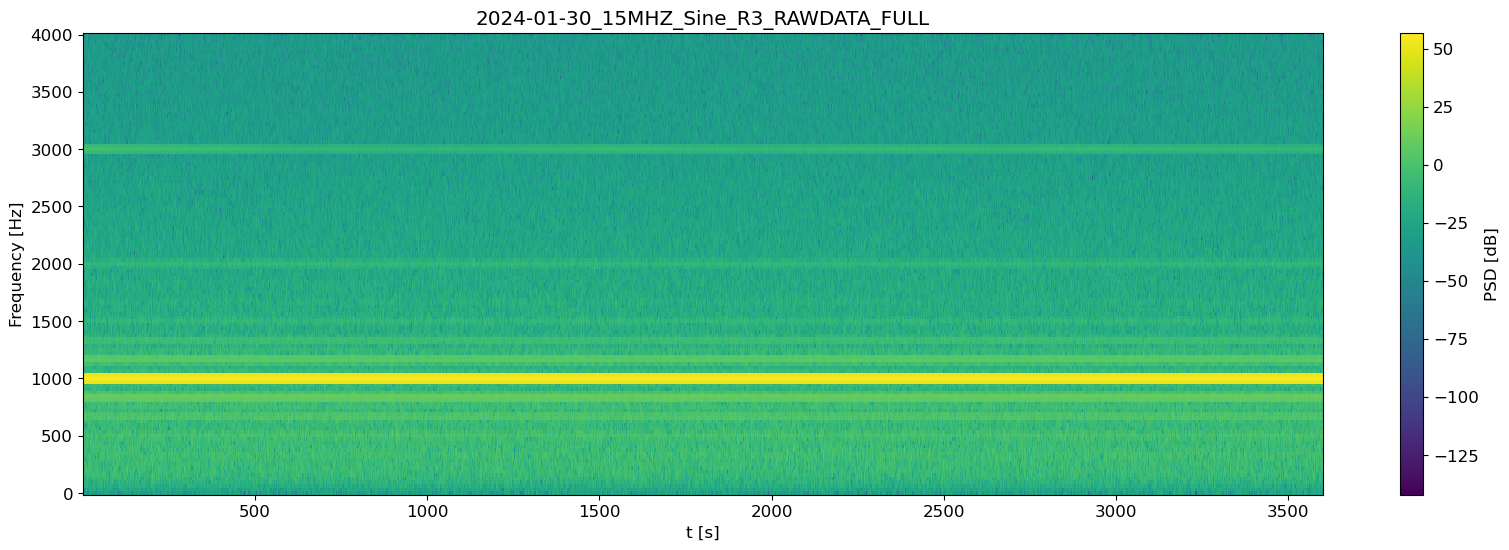

In [11]:
# xlim=(0,60*60)
fig = plt.figure(figsize=(20,6))
ax  = fig.add_subplot(1,1,1)
mpbl = ax.pcolormesh(t_spec,f,Sxx_db)
cbar = fig.colorbar(mpbl,label='PSD [dB]')
ax.set_title(Path(csv_file).stem+"_FULL")
ax.set_xlabel('t [s]')
# ax.set_xlim(xlim)
ax.set_ylabel('Frequency [Hz]')
plt.show()

In [12]:
f, t_spec, Sxx = signal.spectrogram(df[2],fs=fs,window='hann',nperseg=int(fs/0.01))
Sxx_db = 10*np.log10(Sxx)

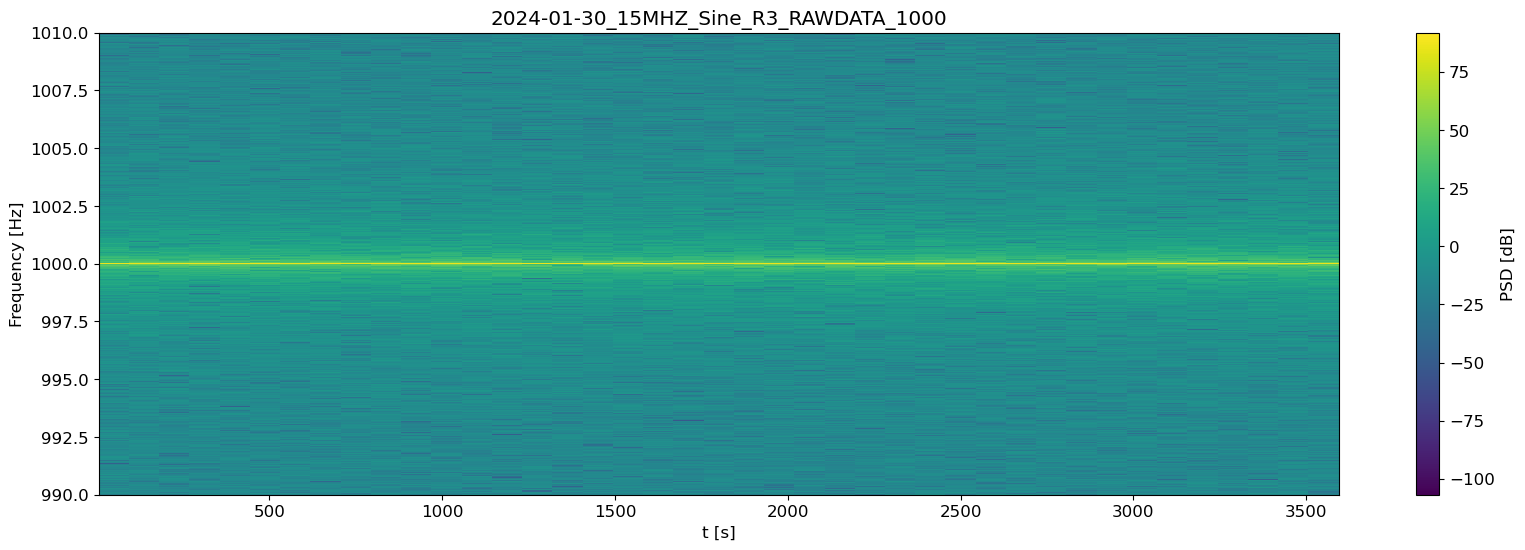

In [13]:
flim = (990,1010)
fig = plt.figure(figsize=(20,6))
ax  = fig.add_subplot(1,1,1)
mpbl = ax.pcolormesh(t_spec,f,Sxx_db)
cbar = fig.colorbar(mpbl,label='PSD [dB]')
ax.set_title(Path(csv_file).stem+"_1000")
ax.set_xlabel('t [s]')
ax.set_ylabel('Frequency [Hz]')
ax.set_ylim(flim)
plt.show()